# Earthquake Impact Analysis in Afghanistan (2022)

## Objective
This notebook aims to analyze and visualize the impact of earthquakes in Afghanistan during the year 2022. By integrating and examining various geospatial datasets, we seek to identify the populations most affected by these seismic events.

## Setup

Before diving into the analysis, it's important to set up our environment by importing all the necessary libraries. This includes libraries for handling HTTP requests, data manipulation, and geospatial analysis. Ensuring that all dependencies are correctly imported at the start helps in avoiding any interruptions in the workflow during the analysis.


In [1]:
import IPython
!python -m pip install httpx ipyleaflet matplotlib geopandas lonboard shapely
IPython.display.clear_output(wait=False)

In [2]:
import httpx
import geopandas as gpd  
import httpx
from shapely.geometry import shape
from lonboard import viz
from ipyleaflet import Map, GeoData, basemaps, LayersControl

## Data Retrieval

In this initial step, our focus is on fetching the relevant vector data from eoAPI. This involves accessing the ingested datasets that pertain to earthquakes and population density in Afghanistan.

We will be using eoAPI's vector endpoints to retrieve information on the vector datasets:

In [3]:
vector_endpoint = "https://eoapi.ifrc-risk.k8s.labs.ds.io/vector"

We can list the available datasets by querying the available collections:

In [4]:
response = httpx.get(f"{vector_endpoint}/collections").json()
collections = response["collections"]
for collection in collections:
    print(collection["id"])


public.population_hexbins_afghanistan
public.health_facilities_afg_osm
public.admin_boundaries_usa_adm0
public.admin_boundaries_usa_adm1
public.earthquake_usgs_gov_shakemap_afg_pga
public.earthquake_usgs_gov_shakemap_afg_psa1p0
public.admin_boundaries_usa_adm2
public.earthquake_usgs_gov_shakemap_afg_pgv
public.earthquake_usgs_gov_shakemap_afg_psa3p0
public.earthquake_usgs_gov_shakemap_afg_psa0p3
public.earthquake_usgs_gov_shakemap_afg_mi
public.postgis_srs
public.postgis_srs_all
public.postgis_srs_search
public.st_subdivide
public.st_hexagongrid
public.st_squaregrid


To achieve our goal of identifying the populations most affected by the earthquakes in Afghanistan, we will utilize two key datasets from the eoAPI:

1. **Population Hexbins (`public.population_hexbins_afghanistan`):**
   This dataset provides detailed information about population density in Afghanistan. The data is structured in hexagonal bins, each representing a specific geographic area, allowing for a precise and comprehensive understanding of population distribution across the country.

2. **Earthquake Shakemap (`public.earthquake_usgs_gov_shakemap_afg_pga`):**
   The Earthquake Shakemap dataset offers crucial data on the intensity of earthquakes in Afghanistan. This information is vital for assessing the severity of the seismic events and their potential impact on different regions.

By integrating these datasets, we aim to create a comprehensive analysis that combines the spatial distribution of the population with the intensity of the earthquake events. This approach will enable us to effectively identify and visualize the areas and populations most affected by the earthquakes.

In [5]:
shake_data_url = f"{vector_endpoint}/collections/public.earthquake_usgs_gov_shakemap_afg_pga/items"
population_hexbins_url =  f"{vector_endpoint}/collections/public.population_hexbins_afghanistan/items"

In [6]:
def get_all_items(url, limit=100, bbox=None):
    all_items = []

    while True:
        params = {"limit": limit, "bbox": bbox}
        response = httpx.get(url, params=params, follow_redirects=True)
        if response.status_code == 200:
            items = response.json()
            all_items.extend(items.get("features", []))
            next_link = next((link["href"] for link in items.get("links", []) if link.get("rel") == "next"), None)
            if next_link:
                url = next_link
            else:
                break
        else:
            print(f"Failed to retrieve data. Status code: {response.status_code}")
            print(response.text)
            break

    return all_items

In [7]:
shake_items = get_all_items(shake_data_url) 
for item in shake_items:
    item['geometry'] = shape(item['geometry'])

shake_gdf = gpd.GeoDataFrame(shake_items)
shake_gdf


,type,geometry,id,properties,links
0,Feature,"MULTIPOLYGON (((61.74457 34.65833, 61.74251 34...",0106000020E61000002700000001030000000100000009...,"{'area': 0.16019918678200099, 'grid_code': 0, ...","[{'title': 'Collection', 'href': 'http://eoapi..."
1,Feature,"MULTIPOLYGON (((62.36422 34.82500, 62.35945 34...",0106000020E61000001100000001030000000100000009...,"{'area': 0.09755802193350067, 'grid_code': 0, ...","[{'title': 'Collection', 'href': 'http://eoapi..."
2,Feature,"MULTIPOLYGON (((61.97526 34.83333, 61.97507 34...",0106000020E61000001400000001030000000100000009...,"{'area': 0.07100332711249933, 'grid_code': 0, ...","[{'title': 'Collection', 'href': 'http://eoapi..."
3,Feature,"MULTIPOLYGON (((62.10833 34.39041, 62.10683 34...",0106000020E61000000A0000000103000000010000007B...,"{'area': 0.04809200000050035, 'grid_code': 0, ...","[{'title': 'Collection', 'href': 'http://eoapi..."
4,Feature,"MULTIPOLYGON (((61.99177 34.72500, 61.99171 34...",0106000020E6100000020000000103000000010000000F...,"{'area': 0.01623074921399997, 'grid_code': 0, ...","[{'title': 'Collection', 'href': 'http://eoapi..."
5,Feature,"MULTIPOLYGON (((62.20022 34.63333, 62.20018 34...",0106000020E61000000300000001030000000100000009...,"{'area': 0.009112916260499952, 'grid_code': 0,...","[{'title': 'Collection', 'href': 'http://eoapi..."
6,Feature,"MULTIPOLYGON (((62.17524 34.68333, 62.17512 34...",0106000020E61000000300000001030000000100000009...,"{'area': 0.00780903868500019, 'grid_code': 0, ...","[{'title': 'Collection', 'href': 'http://eoapi..."
7,Feature,"MULTIPOLYGON (((62.12500 34.60760, 62.12427 34...",0106000020E6100000070000000103000000010000004D...,"{'area': 0.002574332489999989, 'grid_code': 0,...","[{'title': 'Collection', 'href': 'http://eoapi..."
8,Feature,"MULTIPOLYGON (((62.10884 34.66667, 62.10882 34...",0106000020E6100000050000000103000000010000000F...,"{'area': 0.006791921586000074, 'grid_code': 0,...","[{'title': 'Collection', 'href': 'http://eoapi..."
9,Feature,"MULTIPOLYGON (((62.15833 34.55583, 62.15514 34...",0106000020E61000000200000001030000000300000037...,"{'area': 0.006588594361500042, 'grid_code': 0,...","[{'title': 'Collection', 'href': 'http://eoapi..."


In [8]:
afghanistan_lat, afghanistan_lon = 33.9391, 67.7100

m = Map(center=(afghanistan_lat, afghanistan_lon), zoom=6, basemap=basemaps.OpenStreetMap.Mapnik)
geo_data = GeoData(geo_dataframe=shake_gdf,
                   style={'color': 'red', 'fillColor': '#3366CC', 'opacity':0.3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name='GeoDataFrame Layer')
m.add_layer(geo_data)
m.add_control(LayersControl())
m


Map(center=[33.9391, 67.71], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

To optimize the retrieval of hexagon data for earthquake-affected areas, we use a targeted approach that focuses on the specific region of interest. By extracting a bounding box from the earthquake data, we filter the hexagons to include only those within this area. This method significantly reduces the data transferred over the network, ensuring efficient and responsive data retrieval with minimal latency.

This approach not only streamlines the data acquisition process but also conserves valuable network and computational resources. By concentrating on the relevant geographical area, we achieve a more efficient analysis, focusing on the most pertinent data without the overhead of handling the entire dataset.

In [9]:
shake_bbox = httpx.get(f"{vector_endpoint}/collections/public.earthquake_usgs_gov_shakemap_afg_pga").json()["extent"]["spatial"]["bbox"][0]
shake_bbox

[59.983333, 32.833333, 64.35, 36.433333]

In [10]:
bbox = f"{shake_bbox[0]}, {shake_bbox[1]}, {shake_bbox[2]}, {shake_bbox[3]}"

# runs non-stop without bbox
hexbin_items = get_all_items(population_hexbins_url, bbox=bbox) # ~2m
for item in hexbin_items:
    item['geometry'] = shape(item['geometry'])

hexbin_gdf = gpd.GeoDataFrame(hexbin_items)
hexbin_gdf['population'] = hexbin_gdf['properties'].apply(lambda x: int(x['population']))
hexbin_gdf

,type,geometry,id,properties,links,population
0,Feature,"POLYGON ((63.91935 35.98825, 63.92083 35.98330...",0103000020E6100000010000000700000078E04E31ADF5...,"{'h3': '88436bdb1dfffff', 'id': 39, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",2
1,Feature,"POLYGON ((63.90110 35.99282, 63.90258 35.98787...",0103000020E6100000010000000700000086E8132557F3...,"{'h3': '88436bdb55fffff', 'id': 30, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",10
2,Feature,"POLYGON ((63.89486 35.97605, 63.89634 35.97110...",0103000020E61000000100000007000000D1A19BB68AF2...,"{'h3': '88436bdb0dfffff', 'id': 40, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",6
3,Feature,"POLYGON ((63.91310 35.97149, 63.91458 35.96654...",0103000020E610000001000000070000006BC76B9BE0F4...,"{'h3': '88436bdb07fffff', 'id': 41, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",4
4,Feature,"POLYGON ((63.90554 35.97796, 63.90702 35.97301...",0103000020E61000000100000007000000953AB6C8E8F3...,"{'h3': '88436bdb01fffff', 'id': 44, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",1
...,...,...,...,...,...,...
17212,Feature,"POLYGON ((64.16521 35.89890, 64.16667 35.89395...",0103000020E61000000100000007000000B0FC37D9920A...,"{'h3': '88436bc82bfffff', 'id': 146, 'populati...","[{'title': 'Collection', 'href': 'http://eoapi...",1
17213,Feature,"POLYGON ((64.15453 35.89702, 64.15599 35.89207...",0103000020E6100000010000000700000008B427C9E309...,"{'h3': '88436bc829fffff', 'id': 147, 'populati...","[{'title': 'Collection', 'href': 'http://eoapi...",1
17214,Feature,"POLYGON ((64.17274 35.89241, 64.17420 35.88746...",0103000020E610000001000000070000008BA593400E0B...,"{'h3': '88436bc823fffff', 'id': 149, 'populati...","[{'title': 'Collection', 'href': 'http://eoapi...",1
17215,Feature,"POLYGON ((64.17712 35.87755, 64.17858 35.87260...",0103000020E61000000100000007000000F84CFAF5550B...,"{'h3': '88436bc9cdfffff', 'id': 95, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",2



To gain insights into the population distribution within the earthquake-affected area, we need to analyze the data from the hexagons that intersect with this region. This examination is crucial for understanding the potential impact of the earthquake on various population segments and for directing aid and resources efficiently.

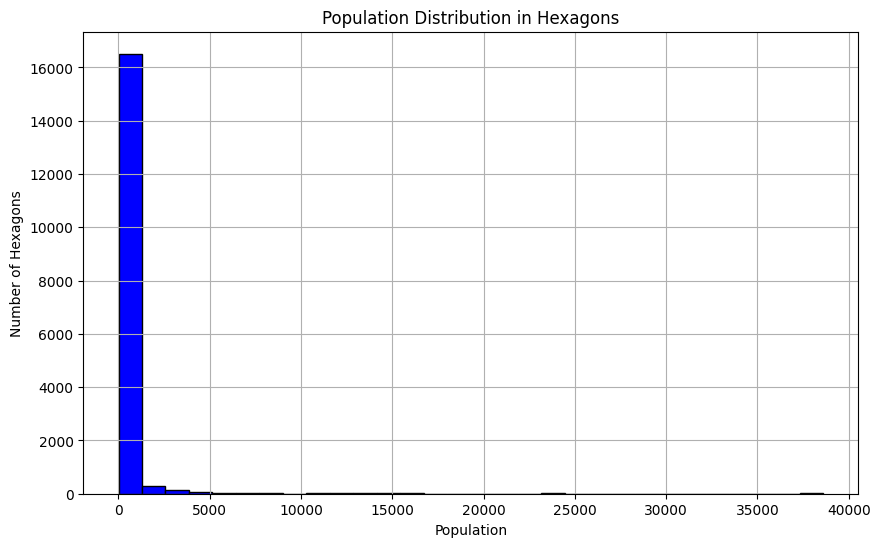

In [11]:
import matplotlib.pyplot as plt

population_data = hexbin_gdf['population']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(population_data, bins=30, color='blue', edgecolor='black')

plt.title('Population Distribution in Hexagons')
plt.xlabel('Population')
plt.ylabel('Number of Hexagons')
plt.grid(True)
plt.show()

Spatial-joins are the key to many geospatial analyses. We can join the population hexagons and the earthquake data to identify key areas impacted by the earthquake.  This process creates a unified dataset that reflects both the population distribution and the severity of the earthquake.

In [12]:
shake_gdf['shake'] = shake_gdf['properties'].apply(lambda x: float(x['paramvalue']))

# Perform the spatial join
joined_gdf = gpd.sjoin(hexbin_gdf, shake_gdf, how="left", op='intersects')
joined_gdf


/Users/zacdez/.pyenv/versions/3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,type_left,geometry,id_left,properties_left,links_left,population,index_right,type_right,id_right,properties_right,links_right,shake
0,Feature,"POLYGON ((63.91935 35.98825, 63.92083 35.98330...",0103000020E6100000010000000700000078E04E31ADF5...,"{'h3': '88436bdb1dfffff', 'id': 39, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",2,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
1,Feature,"POLYGON ((63.90110 35.99282, 63.90258 35.98787...",0103000020E6100000010000000700000086E8132557F3...,"{'h3': '88436bdb55fffff', 'id': 30, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",10,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
2,Feature,"POLYGON ((63.89486 35.97605, 63.89634 35.97110...",0103000020E61000000100000007000000D1A19BB68AF2...,"{'h3': '88436bdb0dfffff', 'id': 40, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",6,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
3,Feature,"POLYGON ((63.91310 35.97149, 63.91458 35.96654...",0103000020E610000001000000070000006BC76B9BE0F4...,"{'h3': '88436bdb07fffff', 'id': 41, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",4,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
4,Feature,"POLYGON ((63.90554 35.97796, 63.90702 35.97301...",0103000020E61000000100000007000000953AB6C8E8F3...,"{'h3': '88436bdb01fffff', 'id': 44, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",1,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
17212,Feature,"POLYGON ((64.16521 35.89890, 64.16667 35.89395...",0103000020E61000000100000007000000B0FC37D9920A...,"{'h3': '88436bc82bfffff', 'id': 146, 'populati...","[{'title': 'Collection', 'href': 'http://eoapi...",1,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
17213,Feature,"POLYGON ((64.15453 35.89702, 64.15599 35.89207...",0103000020E6100000010000000700000008B427C9E309...,"{'h3': '88436bc829fffff', 'id': 147, 'populati...","[{'title': 'Collection', 'href': 'http://eoapi...",1,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
17214,Feature,"POLYGON ((64.17274 35.89241, 64.17420 35.88746...",0103000020E610000001000000070000008BA593400E0B...,"{'h3': '88436bc823fffff', 'id': 149, 'populati...","[{'title': 'Collection', 'href': 'http://eoapi...",1,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01
17215,Feature,"POLYGON ((64.17712 35.87755, 64.17858 35.87260...",0103000020E61000000100000007000000F84CFAF5550B...,"{'h3': '88436bc9cdfffff', 'id': 95, 'populatio...","[{'title': 'Collection', 'href': 'http://eoapi...",2,21,Feature,0106000020E6100000D100000001030000000100000009...,"{'area': 7.159832520022941, 'grid_code': 0, 'i...","[{'title': 'Collection', 'href': 'http://eoapi...",0.01


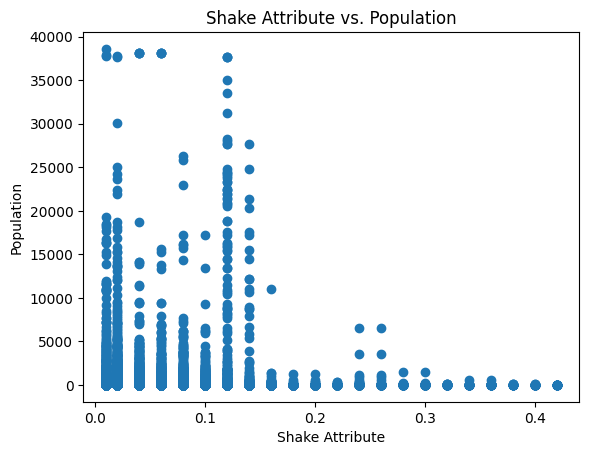

In [13]:
import matplotlib.pyplot as plt

# Assuming 'shake' and 'population' are columns in your joined GeoDataFrame
plt.scatter(joined_gdf['shake'], joined_gdf['population'])
plt.xlabel('Shake Attribute')
plt.ylabel('Population')
plt.title('Shake Attribute vs. Population')
plt.show()


Identifying high-impact areas is crucial for targeted earthquake response and aid. By setting specific thresholds for population and earthquake intensity, we can select areas that are most at risk. These thresholds help in distinguishing regions with high population densities that experienced strong seismic activity, indicating a greater need for assistance. Visualizing these high-impact areas on a map provides a clear and immediate understanding of where resources and aid should be concentrated. This geospatial representation not only aids in efficient allocation of resources but also in communicating the urgency and scale of the situation to stakeholders and the public, ensuring a coordinated and effective response to the earthquake's aftermath.

In [14]:
population_threshold = joined_gdf['population'].quantile(0.9)
shake_threshold = joined_gdf['shake'].quantile(0.9)

high_risk_areas = joined_gdf[(joined_gdf['population'] > population_threshold) & (joined_gdf['shake'] > shake_threshold)]
high_risk_gdf = gpd.GeoDataFrame(high_risk_areas, geometry='geometry')

In [15]:
viz(high_risk_gdf)


Map(layers=[SolidPolygonLayer(table=pyarrow.Table
type_left: string
id_left: string
properties_left: struct<h3…